In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import sys, glob, os, imageio
import numpy as np
import matplotlib.pyplot as plt
import torch
import helper.canon_supervised_dataset as dset
import helper.post_processing as pp
import helper.utils as ut
import matplotlib
import helper.gan_helper_fun as gh
from skimage import exposure
matplotlib.rcParams.update({'font.size': 22})

# View synthetic noise
In this notebook, we load in our pretrained noise model, and show our synthetic noise vs. real noise from our camera.

## Load in saved model

In [2]:
device = 'cuda:0'
gpu = 0
base_folder = 'C:\projects\saved_models'
chkp_name ='noisemodelUnet_shot_read_uniform_row1_rowt_fixed1_periodic_learnedfixed_256_semidark_fourier_yournamehere'
generator = gh.load_from_checkpoint_ab(os.path.join(base_folder, chkp_name), gpu).to(device)
generator.keep_track = True

generator device 0
using learned fixed noise
distributed
current epoch 460


In [3]:
os.path.basename(os.path.join(base_folder, chkp_name))

'noisemodelUnet_shot_read_uniform_row1_rowt_fixed1_periodic_learnedfixed_256_semidark_fourier_yournamehere'

## Load in image 

In [164]:
#options: gan_gray, gan_color, natural 
dataset_arg = 'semidark'
# Change this filepath to point to your downloaded data directory:
filepath_data = 'C:/projects/starlight_denoising/data/'
dataset_list_test = dset.get_dataset_noise_visualization(dataset_arg, filepath_data)

In [165]:
test_loader = torch.utils.data.DataLoader(dataset=dataset_list_test, 
                                           batch_size=1,
                                           shuffle=False) 

In [166]:
len(dataset_list_test)

4

In [167]:
sample = dataset_list_test.__getitem__(1)

In [168]:
for key in sample:
    print(key, sample[key].shape)

noisy_input torch.Size([4, 16, 512, 830])
gt_label_nobias torch.Size([4, 16, 512, 830])


In [169]:
# clean_raw.shape

# d = {'key': clean_raw}
# # dset.RandCrop_gen_lowlightcams()(clean_raw).shape
# dset.FixedCrop_gen(shape=(256, 256))(d)['key'].shape

In [170]:
import cv2

def add_white_noise(image):
    # assuming image of shape (H, W, C)
    noise = np.random.normal(0, 0.1, (image.shape[0], image.shape[1], 1))
    noise = np.repeat(noise, image.shape[2], axis=2).astype(np.float32)
    print(image.shape, noise.shape)
    print(image.max(), image.min(), noise.max(), noise.min())
    print(image.dtype, noise.dtype)
    noisy_image = cv2.add(image, noise)
    # noisy_image = noise
    return noisy_image

def add_white_noise_multiple_frames(image):
    # assuming image of shape (F, C, H, W)
    noise = np.random.normal(0, 0.1, (image.shape[0], 1, image.shape[2], image.shape[3]))
    noise = np.repeat(noise, image.shape[1], axis=1).astype(np.float32)
    print(image.shape, noise.shape)
    print(image.max(), image.min(), noise.max(), noise.min())
    print(image.dtype, noise.dtype)
    noisy_image = cv2.add(image.cpu().detach().numpy(), noise)
    noisy_image = torch.tensor(noisy_image)
    # noisy_image = noise
    return noisy_image

In [171]:
with torch.no_grad():
    sample = dset.RandCrop_gen_lowlightcams(shape=(256, 256))(sample)
    clean_raw = gh.t32(sample['gt_label_nobias'].unsqueeze(0).to(device))
    real_noisy = sample['noisy_input'].cpu().detach().numpy().transpose(1,2,3,0)
    clean_patch = sample['gt_label_nobias'].cpu().detach().numpy().transpose(1,2,3,0)
    
    generator.indices = [10,10]
    print(clean_raw.shape, clean_raw.max(), clean_raw.min(), type(clean_raw))
    # clean_raw = add_white_noise_multiple_frames(clean_raw).to(device)
    print(clean_raw.shape, clean_raw.max(), clean_raw.min(), type(clean_raw))
    gen_noisy = generator(clean_raw, False)
    gen_noisy_np = gen_noisy.cpu().detach().numpy().transpose(0,2,3,1)

torch.Size([16, 4, 256, 256]) tensor(0.8353, device='cuda:0') tensor(0., device='cuda:0') <class 'torch.Tensor'>
torch.Size([16, 4, 256, 256]) tensor(0.8353, device='cuda:0') tensor(0., device='cuda:0') <class 'torch.Tensor'>


In [172]:
print(gen_noisy_np.shape)
print(clean_patch.shape)
print(real_noisy.shape)

(16, 256, 256, 4)
(16, 256, 256, 4)
(16, 256, 256, 4)


In [173]:
clean_patch[0, :, :, 0]
clean_patch[2, :, :, 0].max(), clean_patch[0, :, :, 0].min()

(0.8352941, 0.044509806)

In [176]:
import cv2

def add_white_noise(image):
    # assuming image of shape (H, W, C)
    noise = np.random.normal(0, 0.1, (image.shape[0], image.shape[1], 1))
    noise = np.repeat(noise, image.shape[2], axis=2).astype(np.float32)
    print(image.shape, noise.shape)
    print(image.max(), image.min(), noise.max(), noise.min())
    print(image.dtype, noise.dtype)
    noisy_image = cv2.add(image, noise)
    noisy_image = np.clip(noisy_image, 0, 1)
    # noisy_image = noise
    return noisy_image

def blur_image(image):
    # assuming image of shape (H, W, C)
    blurred = cv2.GaussianBlur(image, (11,11),1.5)
    return blurred

### Additional white noise added to generated noise

0.7352596 0.0
(256, 256, 4) (256, 256, 4)
0.7352596 0.0 0.40574685 -0.37813112
float32 float32
0.9778155 0.0


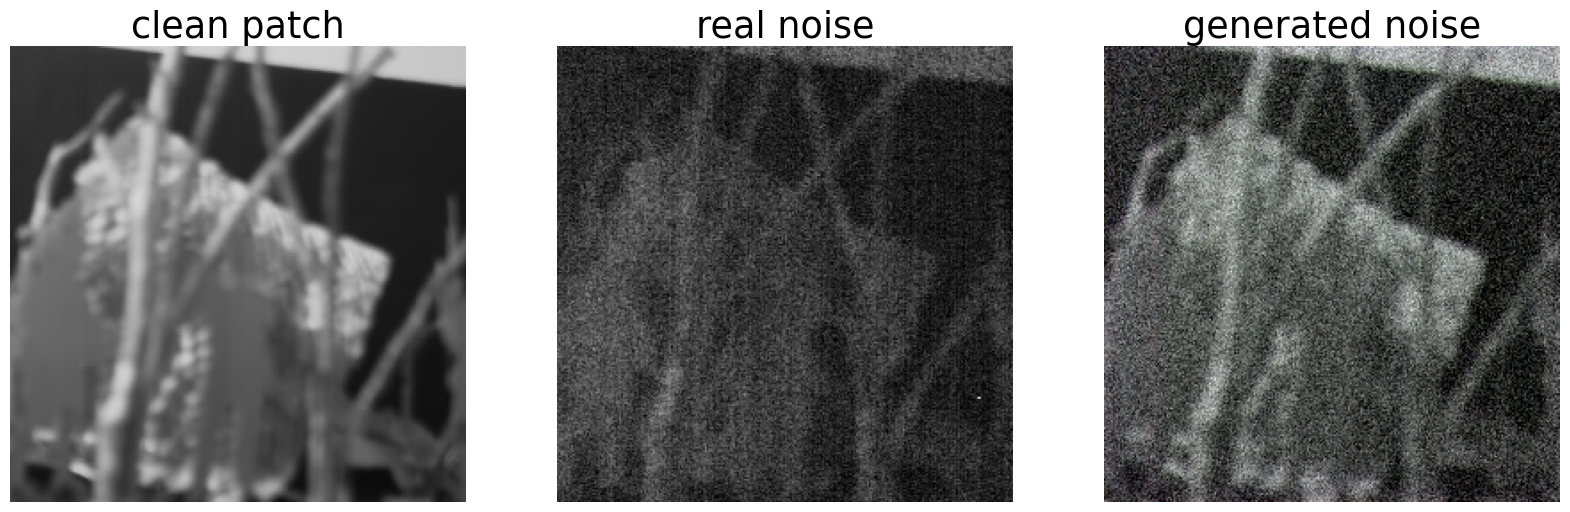

In [179]:
ind = 0
sz = 256
pp = [0,0]

to_plot = [clean_patch[ind], real_noisy[ind], gen_noisy_np[ind]]
titles = ['clean patch', 'real noise', 'generated noise']

to_plot[-1] = blur_image(to_plot[-1])
print(to_plot[-1].max(), to_plot[-1].min())
to_plot[-1] = add_white_noise(to_plot[-1])
print(to_plot[-1].max(), to_plot[-1].min())

# to_plot[0] = blur_image(to_plot[0])
# to_plot[0] = add_white_noise(to_plot[0])

fig, ax = plt.subplots(1,3, figsize = (20,10))
for i in range(0,3):
    # ax[i].imshow(to_plot[i][pp[0]:pp[0]+sz,pp[1]:pp[1]+sz,0:3]**(1/2.2)); 
    ax[i].imshow(to_plot[i][pp[0]:pp[0]+sz,pp[1]:pp[1]+sz,0:3]); 
    ax[i].axis('off');
    ax[i].set_title(titles[i]);


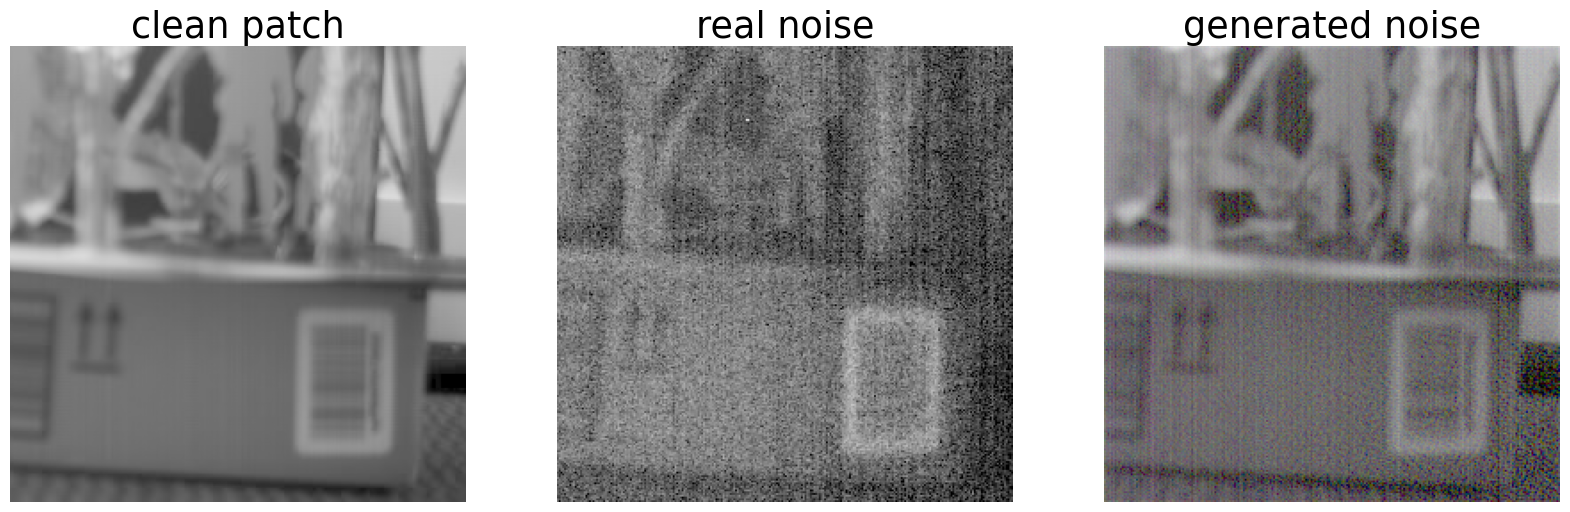

In [143]:
ind = 0
sz = 256
pp = [0,0]

to_plot = [clean_patch[ind], real_noisy[ind], gen_noisy_np[ind]]
titles = ['clean patch', 'real noise', 'generated noise']

fig, ax = plt.subplots(1,3, figsize = (20,10))
for i in range(0,3):
    ax[i].imshow(to_plot[i][pp[0]:pp[0]+sz,pp[1]:pp[1]+sz,0:3]**(1/2.2)); 
    # ax[i].imshow(to_plot[i][pp[0]:pp[0]+sz,pp[1]:pp[1]+sz,0:3]); 
    ax[i].axis('off');
    ax[i].set_title(titles[i]);


## View each noise component separately

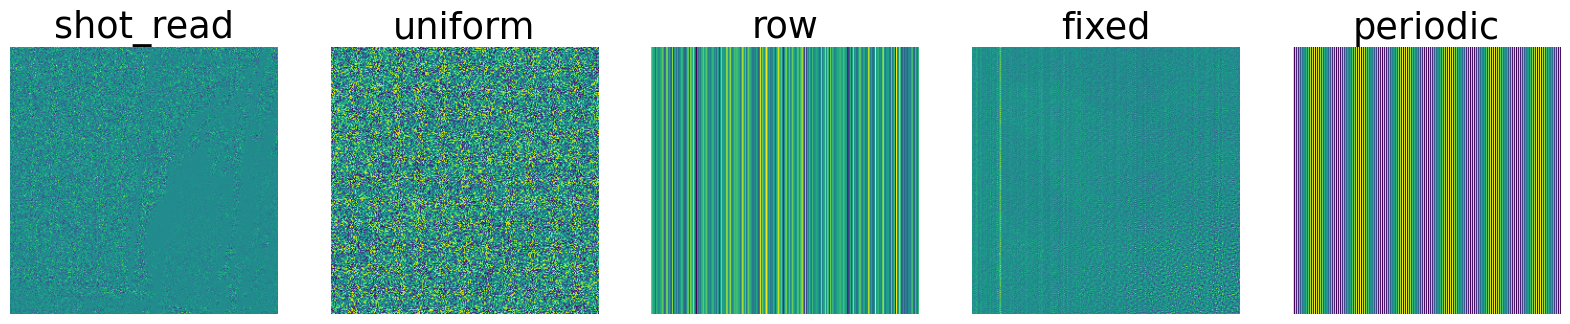

In [106]:
c = 0
all_noise_comps = list(generator.all_noise.keys())
fig, ax = plt.subplots(1,len(all_noise_comps), figsize = (20,10))
for i in range(0,len(all_noise_comps)):
        noise_curr = generator.all_noise[all_noise_comps[i]][0].transpose(1,2,0)[...,0:3]
        ax[i].imshow(noise_curr[...,c])
        ax[i].set_title(all_noise_comps[i])
        ax[i].axis('off')